### 0. Check GPU set up

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15494064905979831625,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7805599744
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12102838610243404348
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"]

### 1. Load Data

In [2]:
%load_ext autoreload
%autoreload 2

from chartbot_config import *

In [3]:
from datasets import load_from_disk

df = load_from_disk(processed_data_path)
df

D:\Anaconda3\envs\GPU\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['index', 'Domain', 'Sub domain', 'Intent', 'Answer Format', 'value', 'labels'],
        num_rows: 9766
    })
    validation: Dataset({
        features: ['index', 'Domain', 'Sub domain', 'Intent', 'Answer Format', 'value', 'labels'],
        num_rows: 3256
    })
    test: Dataset({
        features: ['index', 'Domain', 'Sub domain', 'Intent', 'Answer Format', 'value', 'labels'],
        num_rows: 3256
    })
})

### 2. DataSet Set up

In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = checkpoint

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["value"], truncation=True)

tokenized_dataset = df.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = "tf")

tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns = ["attention_mask", "input_ids", "token_type_ids"],
    label_cols = ["labels"],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = batch_size,
)

tf_validation_dataset = tokenized_dataset["validation"].to_tf_dataset(
    columns = ["attention_mask", "input_ids", "token_type_ids"],
    label_cols = ["labels"],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = batch_size,
)

print("======================================")
print("Trainset:", tf_train_dataset)

100%|██████████| 4/4 [00:00<00:00, 20.16ba/s]


Trainset: <PrefetchDataset shapes: ({input_ids: (32, None), token_type_ids: (32, None), attention_mask: (32, None)}, (32, None)), types: ({input_ids: tf.int64, token_type_ids: tf.int64, attention_mask: tf.int64}, tf.int64)>


### 3. Model Set up

In [5]:
from transformers import TFAutoModelForSequenceClassification

num_labels = len(tokenized_dataset['train']["labels"][0])
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, problem_type="multi_label_classification")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  56906     
Total params: 109,539,146
Trainable params: 109,539,146
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

In [8]:
num_train_steps = len(tf_train_dataset) * max_num_epochs

lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

opt = Adam(learning_rate=lr_scheduler)
loss = BinaryCrossentropy(from_logits=True)

model.compile(
    optimizer = opt,
    loss = loss,
    metrics=["accuracy"],
)

### 4. Model Training

In [9]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs = max_num_epochs
)

Epoch 1/10
305/305 [==============================] - 41s 102ms/step - loss: 0.1376 - accuracy: 0.0119 - val_loss: 0.0721 - val_accuracy: 0.0150
Epoch 2/10
305/305 [==============================] - 30s 98ms/step - loss: 0.0719 - accuracy: 0.0130 - val_loss: 0.0715 - val_accuracy: 0.0117
Epoch 3/10
305/305 [==============================] - 30s 98ms/step - loss: 0.0698 - accuracy: 0.0670 - val_loss: 0.0659 - val_accuracy: 0.2098
Epoch 4/10
305/305 [==============================] - 30s 98ms/step - loss: 0.0598 - accuracy: 0.5078 - val_loss: 0.0503 - val_accuracy: 0.8768
Epoch 5/10
305/305 [==============================] - 30s 98ms/step - loss: 0.0427 - accuracy: 0.9424 - val_loss: 0.0337 - val_accuracy: 0.9693
Epoch 6/10
305/305 [==============================] - 29s 96ms/step - loss: 0.0290 - accuracy: 0.9869 - val_loss: 0.0236 - val_accuracy: 0.9856
Epoch 7/10
305/305 [==============================] - 30s 99ms/step - loss: 0.0213 - accuracy: 0.9927 - val_loss: 0.0182 - val_accuracy

### 5. Model Evaluation 

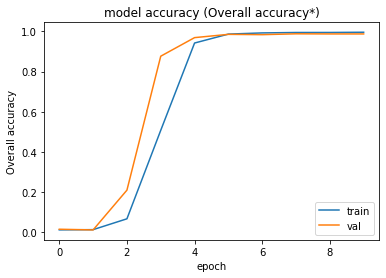

In [10]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (Overall accuracy*)')
plt.ylabel('Overall accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

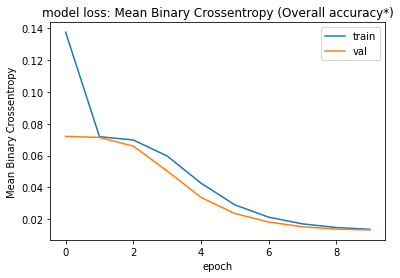

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss: Mean Binary Crossentropy (Overall accuracy*)')
plt.ylabel('Mean Binary Crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [12]:
model.save_weights(model_path)